In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
migration_patterns = pd.read_csv("./arctic_tern_migration.csv") #Data file, needs to be in working directory

#Adds "Month" column to pd dataframe - "Date" is a string: "DD/MM/YYYY", takes characters 3:5=3,4 -> MM and converts it to an integer, then added to dataframe
migration_patterns_months = [int(migration_patterns['Date'][i][3:5]) for i in range(len(migration_patterns["Date"]))]
migration_patterns["Month"] = migration_patterns_months

#Southbound - mostly between Aug/Oct but takes times from Jul/Nov, and latitudes between +/- 40
migration_patterns_sbound = migration_patterns.where(migration_patterns["Month"] > 6).where(migration_patterns["Month"] < 12)\
.where(np.abs(migration_patterns["Lat"]) <= 40).dropna(how="all")

#Rounds latitude for grouping
migration_patterns_sbound["Lat"] = np.round(migration_patterns_sbound["Lat"])

#Latitudes grouped and mean longitude computed. rolling used to smooth data - roll_mean_over can be changed, roll_mean_over = 1 <=> no rolling mean.
roll_mean_over = 3
#migration_patterns_sbound.groupby("Lat").mean("Long")["Long"].rolling(roll_mean_over,center=True).mean()

Lat
-40.0          NaN
-39.0    23.673807
-38.0    21.825780
-37.0    28.299782
-36.0    26.807754
           ...    
 36.0   -27.310537
 37.0   -26.612836
 38.0   -28.757798
 39.0   -27.941673
 40.0          NaN
Name: Long, Length: 80, dtype: float64

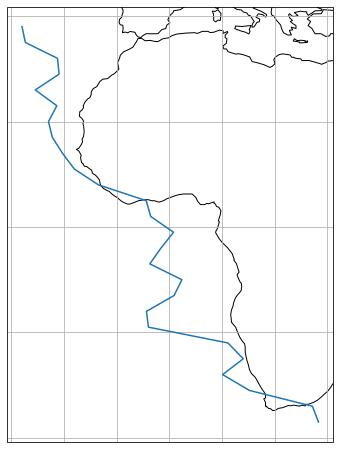

In [3]:
fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
ax.coastlines()
ax.gridlines()

ax.plot(migration_patterns_sbound.groupby("Lat").mean("Long")["Long"].rolling(roll_mean_over,center=True).mean()[::3], np.arange(-40,40)[::3])

fig.savefig("./meanpath.png")

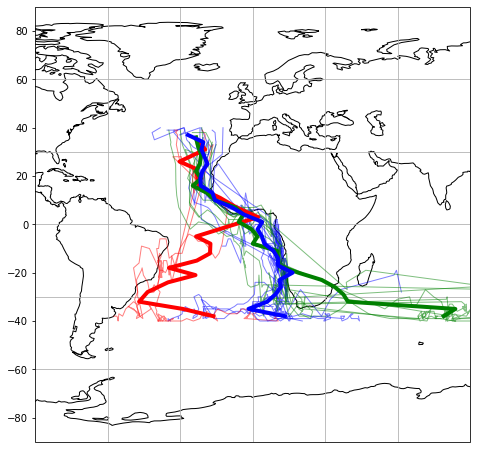

In [8]:
#To plot:

fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
ax.coastlines()
ax.gridlines()

SA_keys = []
AF_keys = []
IO_keys = []

for key, grp in migration_patterns_sbound.groupby(['Bird ID']):
    if grp["Long"].mean() < -20:
        if grp["Bird ID"].all() != "ARTE_390": #removes anomalous bird
            ax = grp.plot(ax=ax, kind='line', x='Long', y='Lat', color="r", linewidth=1, alpha=0.5)
            SA_keys.append(key)
    if np.abs(grp["Long"]).mean() <= 20:
        ax = grp.plot(ax=ax, kind='line', x='Long', y='Lat', color="b", linewidth=1, alpha=0.5)
        AF_keys.append(key)
    if grp["Long"].mean() > 20:
        ax = grp.plot(ax=ax, kind='line', x='Long', y='Lat', color="g", linewidth=1, alpha=0.5)
        IO_keys.append(key)

migration_patterns_sbound_SA = migration_patterns_sbound
migration_patterns_sbound_AF = migration_patterns_sbound
migration_patterns_sbound_IO = migration_patterns_sbound
for key in SA_keys:
    migration_patterns_sbound_IO = migration_patterns_sbound_IO.where(migration_patterns_sbound_IO["Bird ID"] != key)
    migration_patterns_sbound_AF = migration_patterns_sbound_AF.where(migration_patterns_sbound_AF["Bird ID"] != key)
for key in AF_keys:
    migration_patterns_sbound_SA = migration_patterns_sbound_SA.where(migration_patterns_sbound_SA["Bird ID"] != key)
    migration_patterns_sbound_IO = migration_patterns_sbound_IO.where(migration_patterns_sbound_IO["Bird ID"] != key)
for key in IO_keys:
    migration_patterns_sbound_SA = migration_patterns_sbound_SA.where(migration_patterns_sbound_SA["Bird ID"] != key)
    migration_patterns_sbound_AF = migration_patterns_sbound_AF.where(migration_patterns_sbound_AF["Bird ID"] != key)
    
migration_patterns_sbound_SA = migration_patterns_sbound_SA.where(migration_patterns_sbound_SA["Bird ID"] != "ARTE_390")
migration_patterns_sbound_AF = migration_patterns_sbound_AF.where(migration_patterns_sbound_AF["Bird ID"] != "ARTE_390")  
migration_patterns_sbound_IO = migration_patterns_sbound_IO.where(migration_patterns_sbound_IO["Bird ID"] != "ARTE_390")

#ax.plot(migration_patterns_sbound.groupby("Lat").mean("Long")["Long"].rolling(9,center=True).mean(), np.arange(-40,40), color="k", linewidth=3)
ax.plot(migration_patterns_sbound_SA.groupby("Lat").mean("Long")["Long"].rolling(roll_mean_over,center=True).mean()[::-roll_mean_over], sorted(migration_patterns_sbound_SA["Lat"].unique()[1:])[::-roll_mean_over], color="r", linewidth=4)
ax.plot(migration_patterns_sbound_IO.groupby("Lat").mean("Long")["Long"].rolling(roll_mean_over,center=True).mean()[::-roll_mean_over], sorted(migration_patterns_sbound_IO["Lat"].unique()[1:])[::-roll_mean_over], color="g", linewidth=4)
ax.plot(migration_patterns_sbound_AF.groupby("Lat").mean("Long")["Long"].rolling(roll_mean_over,center=True).mean()[::-roll_mean_over], np.unique(sorted(migration_patterns_sbound_AF["Lat"].unique()[1:]))[::-roll_mean_over], color="b", linewidth=4)

legend = ax.legend()
legend.remove()

ax.set_xlim(-90,90)
ax.set_ylim(-90,90)

fig.savefig("./figures/meanpath_grouped.png", dpi=150, bbox_inches="tight")

In [6]:
np.save("./migration_southbound_SA_long.npy", migration_patterns_sbound_SA.groupby("Lat").mean("Long")["Long"].rolling(roll_mean_over, center=True).mean().values[::-roll_mean_over])
np.save("./migration_southbound_IO_long.npy", migration_patterns_sbound_IO.groupby("Lat").mean("Long")["Long"].rolling(roll_mean_over,center=True).mean().values[::-roll_mean_over])
np.save("./migration_southbound_AF_long.npy", migration_patterns_sbound_AF.groupby("Lat").mean("Long")["Long"].rolling(roll_mean_over,center=True).mean().values[::-roll_mean_over])

In [7]:
np.save("./migration_southbound_SA_lat.npy", sorted(migration_patterns_sbound_SA["Lat"].unique()[1:])[::-roll_mean_over])
np.save("./migration_southbound_IO_lat.npy", sorted(migration_patterns_sbound_IO["Lat"].unique()[1:])[::-roll_mean_over])
np.save("./migration_southbound_AF_lat.npy", np.unique(sorted(migration_patterns_sbound_AF["Lat"].unique()[1:]))[::-roll_mean_over])

In [ ]:
#Note: a rolling mean is taken over n=roll_mean_over values, and every nth value is taken, as a simple low pass filter.